In [4]:
import os
from tokenize import group
import numpy as np
import pandas as pd
import time
from math import radians, degrees, sin, cos, asin, acos, sqrt, atan2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import plotly.figure_factory as ff
import matplotlib.collections as mcoll
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from geopy.distance import geodesic
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib.ticker as mticker
import tcmarkers

import pickle  

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from skimage.measure import regionprops
from sklearn.decomposition import PCA

import scipy.ndimage as ndimage
from scipy.stats import gaussian_kde
from scipy.interpolate import interpn
from scipy.ndimage import binary_dilation, minimum_filter, maximum_filter, label
from scipy import integrate
from scipy.sparse import diags, kron
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import cg

from datetime import datetime, timedelta

# import haversine
from haversine import haversine

import tropycal.tracks as tracks

from numba import jit

import itertools    

# from ty_pkg import latlon
from ty_pkg import truncate_colormap, colorline, setup_map, weather_map_contour, contourf_and_save, ep_t, concentric_circles, interpolate_data, set_map
from ty_pkg import latlon_extent, storm_info, haversine_distance, Met, calculate_bearing_position, tc_finder, WindFieldSolver, find_large_groups

pangu_dir = r'/home1/jek/Pangu-Weather'

pres_list = ['1000','925','850','700','600','500','400','300','250','200','150','100','50']
pres=500                                                #살펴볼 기압면 결정
p=pres_list.index(str(pres))
pres_array = np.array(pres_list, dtype=np.float32)

surface_factor = ['MSLP', 'U10', 'V10', 'T2M']
surface_dict = {'MSLP':0, 'U10':1, 'V10':2, 'T2M':3}
upper_factor = ['z', 'q', 't', 'u', 'v']
upper_dict = {'z':0, 'q':1, 't':2, 'u':3, 'v':4}

proj = ccrs.PlateCarree()
norm_p = mcolors.Normalize(vmin=950, vmax=1020)

# Define the colors you want in your colormap
colors = ["purple", "darkblue", "lightblue", "white", "yellow", "red", "pink"]

# Create a colormap from the colors
pwp = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)


# **Bring out TC information**

In [6]:

#! 태풍 경로 정보 기존 정보 불러오기
#위경도 지정
lat_indices, lat_start, lat_end, lon_indices, lon_start, lon_end, extent, latlon_ratio = latlon_extent(100,160,5,45)  
lon_grid, lat_grid = np.meshgrid(lon_indices[lon_start:lon_end + 1], lat_indices[lat_start:lat_end + 1])


ssv_dict = {}


#태풍 지정
storm_name = 'hinnamnor'                                                                               
storm_name = storm_name.upper()
storm_year = 2022

surface_factors = []  # 예시: 지표면에서는 'MSLP'만 선택
upper_factors = ['z'] 
perturation_scale = 0.05

#예측 시간 지정, 초기 시간 지정, 앙상블 수
key_time_list = ['2022/08/27/00UTC']
predict_interval_list = np.arange(0,24*7+1,6)  
ens_list = range(0,4000)
new_ssv = 'n'           #새로 생성할 것인지 여부, n이면 기존 파일 불러옴
retro_opt = 'td'        #다시 돌아가면서 태풍 추적시 강한 것만 추적하려면 td로

if retro_opt =='td':
    retro_opt = '_td'
else:
    retro_opt = ''
        
#! 태풍 경로 정보 새로 생성하기
if new_ssv == 'y':
    for first_str in key_time_list:
        first_time = datetime.strptime(first_str, "%Y/%m/%d/%HUTC")
        key_str = first_time.strftime("%m.%d.%HUTC")
        ssv_key = first_time
        surface_factors.sort()
        upper_factors.sort()
        surface_str = "".join([f"_{factor}" for factor in surface_factors])  # 각 요소 앞에 _ 추가
        upper_str = "".join([f"_{factor}" for factor in upper_factors])  # 각 요소 앞에 _ 추가


        datetime_list = np.array([first_time + timedelta(hours=int(hours)) for hours in predict_interval_list])
        # datetime_array = np.array([(first_time + timedelta(hours=int(hours))) for hours in predict_interval_list])

        storm_lon, storm_lat, storm_mslp, storm_time = storm_info(pangu_dir, storm_name, storm_year, datetime_list = datetime_list, wind_thres=0)   #태풍 영문명, 년도 입력

        min_position = {}  # 태풍 중심 정보 dictionary



        # for ens in range(ens_num):
        for ens in ens_list:
            print(f'{ens}번째 앙상블 예측')
            min_position[ens] = {}
            output_data_dir = rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/{ens}'
            
            
            
            for predict_interval in predict_interval_list:
                predict_time = first_time + timedelta(hours=int(predict_interval))
                predict_str = predict_time.strftime("%Y/%m/%d/%HUTC")
                met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid)
                mslp = met.met_data('MSLP')
                wind_speed = met.wind_speed()
                z_diff = met.met_data('z', level = 300) - met.met_data('z', level = 500)
              
                #mask_size는 다음 태풍 찾을 때 그 위경도 안이 아니면 안 찾음S
                #처음 시작할 때는 5도 이내에만 들어오면 되고
                #mslp_z_dis는 250이 기본인데 이는 mslp 지역 최솟값과 z지역 최댓값이 250km 이내여야 pass
                #mslp_2hpa는 주변 8방위로 2hPa이 감소하는지 보는건데 일단은 'n'으로 걸어둠
                #아래에서는 mask_size말고는 아무런 제약을 안 걸었음
                min_position[ens] = tc_finder(mslp, lat_indices, lon_indices, lat_start, lon_start, lat_grid, lon_grid, 
                                        wind_speed, predict_time, z_diff, storm_lon, storm_lat, storm_mslp, storm_time, 
                                        min_position[ens], mask_size = 2.5, init_size=5, local_min_size = 5, mslp_z_dis = 250, wind_thres=8)

            
            for predict_interval in predict_interval_list[::-1]:
                predict_time = first_time + timedelta(hours=int(predict_interval))
                predict_str = predict_time.strftime("%Y/%m/%d/%HUTC")
                met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid)
                mslp = met.met_data('MSLP')
                wind_speed = met.wind_speed()
                z_diff = met.met_data('z', level = 300) - met.met_data('z', level = 500)
                
                if retro_opt != '_td':
                    min_position[ens] = tc_finder(mslp, lat_indices, lon_indices, lat_start, lon_start, lat_grid, lon_grid, 
                                                wind_speed, predict_time, z_diff, storm_lon, storm_lat, storm_mslp, storm_time, 
                                                min_position[ens], mask_size = 2.5, local_min_size = 5, back_prop='y', mslp_z_dis = 1000, wind_thres=8)
                else:
                    min_position[ens] = tc_finder(mslp, lat_indices, lon_indices, lat_start, lon_start, lat_grid, lon_grid, 
                                                wind_speed, predict_time, z_diff, storm_lon, storm_lat, storm_mslp, storm_time, 
                                                min_position[ens], mask_size = 2.5, local_min_size = 5, back_prop='y', mslp_z_dis = 250, wind_thres=8)
                    
                
                min_position[ens] = {k: min_position[ens][k] for k in sorted(min_position[ens])}
                
        ssv_dict[ssv_key] = min_position

    with open(rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/ssv_dict{retro_opt}_{min(ens_list)}_{max(ens_list)}.pkl', 'wb') as f:
        pickle.dump(ssv_dict, f)

else:
    for first_str in key_time_list:
        first_time = datetime.strptime(first_str, "%Y/%m/%d/%HUTC")
        key_str = first_time.strftime("%m.%d.%HUTC")
        ssv_key = first_time
        surface_factors.sort()
        upper_factors.sort()
        surface_str = "".join([f"_{factor}" for factor in surface_factors])  # 각 요소 앞에 _ 추가
        upper_str = "".join([f"_{factor}" for factor in upper_factors])  # 각 요소 앞에 _ 추가
        
        datetime_list = np.array([first_time + timedelta(hours=int(hours)) for hours in predict_interval_list])
        # datetime_array = np.array([(first_time + timedelta(hours=int(hours))) for hours in predict_interval_list])
        storm_lon, storm_lat, storm_mslp, storm_time = storm_info(pangu_dir, storm_name, storm_year, datetime_list = datetime_list, wind_thres=0)   #태풍 영문명, 년도 입력

        
        with open(rf'/data03/Pangu_TC_ENS/{perturation_scale}ENS{surface_str}{upper_str}/ssv_dict{retro_opt}_{min(ens_list)}_{max(ens_list)}.pkl', 'rb') as f:
            ssv_dict = pickle.load(f)
        

## Draw TC tracks

In [ ]:
for key_time ,min_position in ssv_dict.items():
    fig, ax = plt.subplots(1, 1, figsize=(10*latlon_ratio, 10), subplot_kw={'projection': proj})
    key_str = key_time.strftime("%m.%d.%HUTC")
    # ax.set_title(f'{key_time.strftime("%Y-%m-%d-%HUTC")} (+{predict_interval_list[-1]}h)', fontsize=20, loc = 'left')
    # ax.set_title(f'ENS{surface_str}{upper_str}{perturation_scale} Track\n{storm_name}', fontsize=20, loc = 'right')
    # ax.set_title(f'{storm_name}', fontsize=20, loc = 'right')
    ax.set_extent([120,155,20,45], crs=proj)
    setup_map(ax)

    ax.plot(storm_lon, storm_lat, color='black', linestyle='-', marker='', label = 'Best track', transform=ax.projection, zorder=10)
    model_pred_sc = ax.scatter(storm_lon, storm_lat, c=storm_mslp, cmap='jet_r', marker='^',norm=norm_p, transform=ax.projection, zorder=10)
    cbar = plt.colorbar(model_pred_sc, ax=ax, orientation='vertical', label='MSLP (hPa)', shrink=0.8)
    cbar.ax.tick_params(labelsize=15)

    
    for i in range(len(storm_time)):
        new_time = storm_time[i].strftime("%Y/%m/%d/%HUTC")
        if new_time.endswith('00UTC'):
            dx, dy = 5, -0.5  # 시간 나타낼 위치 조정
            new_lon, new_lat = storm_lon[i] + dx, storm_lat[i] + dy
            
            # annotate를 사용하여 텍스트와 함께 선(화살표)을 그림
            ax.text(storm_lon[i], new_lat, new_time[8:-6]
                    , horizontalalignment='right', verticalalignment='top', fontsize=15, zorder = 20, fontweight = 'bold')



    # for ens in range(ens_num):  
    for ens in ens_not_list[:10]:  


        lons = [pos['lon'] for _,pos in min_position[ens].items()]
        lats = [pos['lat'] for _,pos in min_position[ens].items()]
        min_values = [pos['mslp'] for _,pos in min_position[ens].items()]
        pred_times = [pos for pos,_ in min_position[ens].items()]
        # print(ens)
        lc = colorline(ax, lons, lats, z=min_values, cmap=plt.get_cmap('jet_r'), norm=mcolors.Normalize(vmin=950, vmax=1020), linewidth=2, alpha=1)

        #? 시간 표시 00UTC만 표시, 없앨듯

        # if ens == 0:
        #     lc = colorline(ax, lons, lats, z=min_values, cmap=plt.get_cmap('jet_r'), norm=mcolors.Normalize(vmin=950, vmax=1020), linewidth=2, alpha=1)
        #     ax.scatter(lons, lats, c='red', linewidth=2, alpha=1, zorder=10, label = 'No perturbation')

        for i in range(len(pred_times)):
            if pred_times[i].hour == 0:
                ax.text(lons[i],lats[i], str(pred_times[i].day)
                    , horizontalalignment='center', verticalalignment='bottom', fontsize=10, zorder = 6)

        
    ax.legend(loc='upper right')


    lons_all = np.concatenate([np.array([pos['lon'] for _, pos in min_position[ens].items()]) for ens in ens_list])
    lats_all = np.concatenate([np.array([pos['lat'] for _, pos in min_position[ens].items()]) for ens in ens_list])


    xy = np.vstack([lons_all, lats_all])
    kde = gaussian_kde(xy)
    positions = np.vstack([lon_grid.ravel(), lat_grid.ravel()])
    f = np.reshape(kde(positions).T, lon_grid.shape)


    levels = np.linspace(0.0005, 0.015, 100)
    # cf = ax.contourf(lon_grid, lat_grid, f, levels=levels, transform=proj, cmap='jet')
    plt.show()
    # fig.savefig(f'{pangu_dir}/plot/Ensemble_track_{key_str}.png',bbox_inches='tight')
    


## **Original Method sensitivity**

In [7]:
#! 가장 상관관계 높은 axis 구하기, 2nd main code
# 시간 지정
key_time = datetime(2022,8,27,0)            #처음 시점 지정
start_time = datetime(2022,8,28,0)          #분석 시작 시점
target_time = datetime(2022,9,1,0)          #위치 projection을 구하고자 하는 시간

key_str = key_time.strftime("%m.%d %HUTC")
start_str = start_time.strftime("%m.%d %HUTC")
target_str = target_time.strftime("%m.%d %HUTC")

total_time_range = int((target_time - key_time).total_seconds() / 3600)
start_time_range = int((start_time  - key_time).total_seconds() / 3600)

# 변수 지정
nearby_sign = 'n'                           #가까운 태풍만 추출
distance_threshold = 0                      #가까운 태풍의 거리
steering_sign = 'y'                         #태풍 제거를 진행할 것인지를 판단(steering wind 진행)
steer_uni_alt = 0                           #steering wind를 구할 때, 고도를 하나
# choosen_factor_list = ['z','t','q']       #구하고자 하는 변수
choosen_factor_list = ['z']                 #구하고자 하는 변수
# altitude_list = [1000,850,700,500,300,200]#각 변수에 대해 구하고자 하는 고도
altitude_list = [850,500,250]               #각 변수에 대해 구하고자 하는 고도
steer_pres = [850,700,600,500,400,300,250]  #steering wind 구할 때 사용하는 고도 바꿀 필요 x
axis_opt = 'quiver'                         #axis 뭘로 잡을지, opt: 위치 상관관계 최대인 axis, tar: 최종 위치의 axis, mid: 중간 위치의 axis, lon: 경도, lat: 위도
data_sign = 'y'                             #기존의 데이터를 사용할 것인지, n이면 새로 구함

if nearby_sign == 'y':
    nearby_sign_name = '_nearby'
else:
    nearby_sign_name = ''
    

# steering_sign이 y면 steering wind에 대해서만 구하기
if steering_sign == 'y':
    altitude_list = ['850_200']
    choosen_factor_list = ['steering_wind']
    

ens_num_list = []
ens_not_list = []

for ens in ens_list:
    if (target_time in ssv_dict[key_time][ens]) and (start_time in ssv_dict[key_time][ens]):
        ens_num_list.append(ens)
    else:
        ens_not_list.append(ens)

print(len(ens_num_list), len(ens_not_list))


for predict_interval in np.arange(0,120+1,6):
    datetime1 = key_time + timedelta(hours=int(predict_interval))
    ens_num_list = []

    for ens in ens_list:
        if (datetime1 in ssv_dict[key_time][ens]):
            ens_num_list.append(ens)

    print(predict_interval, len(ens_num_list))


#%%
# target_time 때도 살아있는 태풍만 추출
correlations = []
correlations_tar = []
correlations_opt = []
correlations_gg = []
correlations_df = []
correlations_all = []
ens_num_list = []
cov_var_nearby = {}
cov_var_conv = {}
cov_var_conv_norm = {}


dir_all = {}
sensitivity_sum = []
for predict_interval in np.arange(start_time_range,total_time_range+1,6):
# for predict_interval in np.arange(start_time_range,120+1,6):
# for predict_interval in np.arange(54,total_time_range+1,6):
# for predict_interval in np.arange(start_time_range,36+1,6):
# for predict_interval in np.arange(start_time_range, 37, 6):
# for predict_interval in np.arange(24,25,12):

    cov_var_conv[predict_interval] = {'map': {}, 'inner': {}}
    cov_var_conv_norm[predict_interval] = {'map': {}, 'inner': {}}
# for predict_interval in [24,72]:
    datetime1 = key_time + timedelta(hours=int(predict_interval))

    ens_num_list = []
    for ens in ens_list:
        if (target_time in ssv_dict[key_time][ens]) and (start_time in ssv_dict[key_time][ens]):
            ens_num_list.append(ens)
    

    

    mid_pos = [(ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']) for ens in ens_num_list]
    tar_pos = [(ssv_dict[key_time][ens][target_time]['lon'], ssv_dict[key_time][ens][target_time]['lat']) for ens in ens_num_list]
    
    # NumPy 배열로 변환
    mid_pos, tar_pos = np.array(mid_pos), np.array(tar_pos)
    
    # 경도의 왜곡을 보정
    corr_pos_tar = np.copy(tar_pos)
    corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
    pca_tar = PCA(n_components=1)
    pca_tar.fit(corr_pos_tar)
    pca_tar.mean_[0] = pca_tar.mean_[0] / np.cos(np.radians(pca_tar.mean_[1])) + np.mean(tar_pos[:, 0])

    
    if nearby_sign == 'y':
        tar_pos, mid_pos, group_idx = find_large_groups(mid_pos, ens_num_list, tar_pos, nearby_sign, distance_threshold, 1, 10)
        print(len(ens_num_list), len(group_idx))
        
    corr_pos_mid = np.copy(mid_pos)
    corr_pos_mid[:, 0] = (mid_pos[:, 0]-np.mean(mid_pos[:, 0])) * np.cos(np.radians(mid_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
    pca_mid = PCA(n_components=1)
    pca_mid.fit(corr_pos_mid)
    pca_mid.mean_[0] = pca_mid.mean_[0] / np.cos(np.radians(pca_mid.mean_[1])) + np.mean(mid_pos[:, 0])
    
    #distance 구하기
    corr_pos_tar = np.copy(tar_pos) #nearby를 고려하여 다시 target 부르기 PCA는 전체 데이터로 해야되므로 nearby 이전에 진행
    corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
    projection = pca_tar.transform(corr_pos_tar)[:, 0]  # 주축에 투영된 데이터 (1차원)
    principal_component = pca_tar.components_[0]

    # 투영된 데이터의 ensemble mean 계산
    ensemble_mean = np.mean(projection)

    # 각 앙상블 멤버의 투영 데이터와 ensemble mean 사이의 거리 계산
    distances = projection - ensemble_mean

    # 각 앙상블 멤버의 거리를 저장
    ensemble_distances = {ens: distance for ens, distance in zip(ens_num_list, distances)}

    # 데이터를 추출합니다
    ens_pos = [(ens, ssv_dict[key_time][ens][target_time]['lon'], ssv_dict[key_time][ens][target_time]['lat']) for ens in ens_num_list]

    # 위도(lat) 기준으로 데이터를 정렬합니다
    ens_pos_sorted = sorted(ens_pos, key=lambda x: ensemble_distances[x[0]])

    # 위도가 가장 낮은 10개와 가장 높은 10개를 추출합니다
    group1 = ens_pos_sorted[:20]  # 가장 낮은 10개
    group2 = ens_pos_sorted[-20:]  # 가장 높은 10개
    group3 = ens_pos_sorted[len(ens_pos_sorted) // 2 - 5:len(ens_pos_sorted) // 2 + 5]
    
    # group1과 group2에 있는 ens 번호만 추출합니다
    group1 = [item[0] for item in group1]
    group2 = [item[0] for item in group2]
    group3 = [item[0] for item in group3]
    group1_idx = np.array([ens_num_list.index(idx) for idx in group1])
    group2_idx = np.array([ens_num_list.index(idx) for idx in group2])
    group3_idx = np.array([ens_num_list.index(idx) for idx in group3])
    
    
    mid_proj = pca_mid.transform(mid_pos)
    tar_proj = pca_tar.transform(tar_pos)
    mid2tar = pca_tar.transform(mid_pos)
    mid_re = pca_mid.inverse_transform(mid_proj)
    tar_re = pca_tar.inverse_transform(tar_proj)
    tar2mid = pca_tar.inverse_transform(mid2tar)

    
    uv_all_alt = {}
    uv_all_1 = {}
    uv_all_2 = {}
    for choosen_factor in choosen_factor_list:
        uv_all_alt[choosen_factor] = []
        uv_all_1[choosen_factor] = []
        uv_all_2[choosen_factor] = []
        for altitude in altitude_list:
            fig_dir = f'/home1/jek/Pangu-Weather/plot/Sensitivity/{key_str}/{start_str}_{target_str}_{axis_opt}{nearby_sign_name}/'
            print(choosen_factor, altitude)     
            ens_factor_uv=[]
            total_remove_uv = []
            u_mean_each = []
            v_mean_each = []

            steer_quiver = {'u':[],'v':[]}
            steer_quiver_total = {'u':[],'v':[]}
            steer_quiver_g1 = {'u':[],'v':[]}
            steer_quiver_g2 = {'u':[],'v':[]}
            
            base_output_path = os.path.join(
                pangu_dir, 
                'output_data', 
                'steering_wind',
                key_str, 
                f'{perturation_scale}ENS{surface_str}{upper_str}', 
                f'{min(ens_list)}_{max(ens_list)}_{start_str}_{target_str}'
            )

            # Paths for saving the arrays
            ens_factor_uv_path = os.path.join(base_output_path, 'ens_factor_uv')
            total_remove_uv_path = os.path.join(base_output_path, 'total_remove_uv')
            u_mean_path = os.path.join(base_output_path, 'u_mean')
            v_mean_path = os.path.join(base_output_path, 'v_mean')
            
            if data_sign == 'n':
                for ens in ens_num_list:
                    center_lon, center_lat = ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']
                    
                    output_data_dir = rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/{ens}'
                    met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid)
                    
                    if choosen_factor != 'steering_wind':
                        ens_factor_uv.append(met.met_data(choosen_factor, level = altitude))
                    else:
                        u_list = []
                        v_list = []
                        
                        
                        if len(steer_pres) > 1:
                            dis_cal_sign = 'y'
                            final_mask = None
                            for steer_altitude in steer_pres:
                                
                                div = met.divergence(level = steer_altitude)
                                vort = met.vorticity(level = steer_altitude)
                                vort_850 = met.vorticity(level = 850)
                                
                                if steering_sign == 'y':
                                    ty_wind = WindFieldSolver(lat_grid, lon_grid, center_lat, center_lon, vort, div, vort_850, dis_cal_sign = dis_cal_sign, final_mask = final_mask)
                                    dis_cal_sign = 'n'
                                    u_ty, v_ty, final_mask = ty_wind.solve()
                                    u_list.append(met.met_data('u', level = steer_altitude)-u_ty)
                                    v_list.append(met.met_data('v', level = steer_altitude)-v_ty)
                                    # u_list.append(met.met_data('u', level = steer_altitude))
                                    # v_list.append(met.met_data('v', level = steer_altitude))

                                else:
                                    u_list.append(met.met_data('u', level = steer_altitude))
                                    v_list.append(met.met_data('v', level = steer_altitude))
                                    
                            u,v = np.zeros(np.shape(u_list[0])), np.zeros(np.shape(u_list[0]))
                            
                        
                            for i in range(len(steer_pres)-1):
                                u += (u_list[i]+u_list[i+1])/2*(steer_pres[i]-steer_pres[i+1])
                                v += (v_list[i]+v_list[i+1])/2*(steer_pres[i]-steer_pres[i+1])
                            
                            u/=np.ptp(steer_pres)
                            v/=np.ptp(steer_pres)
                            
                        else:
                            div = met.divergence(level = steer_pres[0])
                            vort = met.vorticity(level = steer_pres[0])
                            
                            if steering_sign == 'y':
                                ty_wind = WindFieldSolver(lat_grid, lon_grid, center_lat, center_lon, vort, div, vort_850)
                                u_ty, v_ty = ty_wind.solve()
                                u = met.met_data('u', level = steer_pres[0]-u_ty)
                                v = met.met_data('v', level = steer_pres[0]-v_ty)
                                
                            else:
                                u = met.met_data('u', level = steer_pres[0])
                                v = met.met_data('v', level = steer_pres[0])
                        
                        u_mean_each.append(u)
                        v_mean_each.append(v)
                        # ens_factor.append(u * best_direction[0] + v * best_direction[1])
                        ens_factor_uv.append([u,v])
                        total_remove_uv.append([u_list, v_list])
                        
                        if ens == 0:
                            u0 = u
                            v0 = v
                            
                u_mean = np.mean(np.array(u_mean_each), axis=0)
                v_mean = np.mean(np.array(v_mean_each), axis=0)
            
                # Ensure the figure directory exists
                # fig_path = os.path.join(fig_dir, f'{altitude}hPa')
                # os.makedirs(fig_path, exist_ok=True)

                # Base path for output data


            
            else:
                ens_factor_uv = np.load(f'{ens_factor_uv_path}/{predict_interval}h{retro_opt}.npy')
                total_remove_uv = np.load(f'{total_remove_uv_path}/{predict_interval}h{retro_opt}.npy')
                
                u_mean = np.load(f'{u_mean_path}/{predict_interval}h{retro_opt}.npy')
                v_mean = np.load(f'{v_mean_path}/{predict_interval}h{retro_opt}.npy')
                
                if steer_uni_alt in steer_pres:
                    ens_factor_uv = total_remove_uv[:,:,steer_pres.index(steer_uni_alt),:,:]
                    u_mean = np.mean(ens_factor_uv[:,0,:,:], axis=0)
                    v_mean = np.mean(ens_factor_uv[:,1,:,:], axis=0)
                
                if choosen_factor == 'u':
                    ens_factor_uv = ens_factor_uv[:,0,:,:]
                    total_remove_uv = total_remove_uv[:,0,:,:,:]
                    
                elif choosen_factor == 'v':
                    ens_factor_uv = ens_factor_uv[:,1,:,:]
                    total_remove_uv = total_remove_uv[:,1,:,:,:]
            
                if nearby_sign == 'y':
                    if data_sign == 'y':
                        ens_factor_uv = np.array(ens_factor_uv)[group_idx]
                    
                    if steering_sign == 'y':
                        u_mean = np.mean(ens_factor_uv[:,0,:,:], axis=0)
                        v_mean = np.mean(ens_factor_uv[:,1,:,:], axis=0)
            
            
            non_uv_mean = np.mean(ens_factor_uv, axis=0)
            
                     

            # z_500 데이터를 numpy 배열로 변환
            ens_factor = np.array(ens_factor_uv)
            
            if steering_sign == 'y':
                ens_factor_quiver = (ens_factor[:,0,:,:], ens_factor[:,1,:,:])
                
                cov_var_ratio = {}
                cov_var_ratio_norm = {}
                cov_var_inner = {'u':[],'v':[]}
                cov_var_inner_norm = {'u':[],'v':[]}
                for ens_factor, uv_key in zip(ens_factor_quiver,['u','v']):
                    ens_factor_std = np.std(ens_factor, axis=0)
                    ens_norm = (ens_factor - np.mean(ens_factor, axis=0)) / ens_factor_std

                    # 공분산 및 분산 계산
                    cov_matrix = np.zeros_like(ens_factor[0])
                    var_matrix = np.zeros_like(ens_factor[0])
                    cov_matrix_norm = np.zeros_like(ens_norm[0])
                    var_matrix_norm = np.zeros_like(ens_norm[0])

                    for i in range(ens_factor.shape[1]):  # lat 방향
                        for j in range(ens_factor.shape[2]):  # lon 방향
                            cov_matrix[i, j] = np.cov(distances, ens_factor[:, i, j])[0, 1]
                            var_matrix[i, j] = np.var(ens_factor[:,i,j])
                            cov_matrix_norm[i, j] = np.cov(distances, ens_norm[:, i, j])[0, 1]
                            var_matrix_norm[i, j] = np.var(ens_norm[:,i,j])

                

                    # NaN 또는 Inf 값을 0으로 대체
                    cov_var_ratio[uv_key] = np.nan_to_num(cov_matrix / var_matrix * 111)
                    cov_var_ratio_norm[uv_key]  = np.nan_to_num(cov_matrix_norm / var_matrix_norm * 111)
                    
                    

                for k, mp in enumerate(mid_pos):
                    dis = haversine_distance(lat_grid, lon_grid, np.ones_like(lat_grid)*mp[1], np.ones_like(lat_grid)*mp[0])
                    cov_var_inner['u'].append(np.mean(cov_var_ratio['u'][dis <= 333]))
                    cov_var_inner['v'].append(np.mean(cov_var_ratio['v'][dis <= 333]))
                    cov_var_inner_norm['u'].append(np.mean(cov_var_ratio_norm['u'][dis <= 333]))
                    cov_var_inner_norm['v'].append(np.mean(cov_var_ratio_norm['v'][dis <= 333]))
                    steer_quiver['u'].append(np.mean(ens_factor_uv[k,0,:,:][dis <= 333]))
                    steer_quiver['v'].append(np.mean(ens_factor_uv[k,1,:,:][dis <= 333]))
                    steer_quiver_total['u'].append(ens_factor_uv[k,0,:,:])
                    steer_quiver_total['v'].append(ens_factor_uv[k,1,:,:])

                for g1_idx, g2_idx in zip(group1_idx, group2_idx):
                    steer_quiver_g1['u'].append(ens_factor_uv[g1_idx,0,:,:])
                    steer_quiver_g1['v'].append(ens_factor_uv[g1_idx,1,:,:])
                    steer_quiver_g2['u'].append(ens_factor_uv[g2_idx,0,:,:])
                    steer_quiver_g2['v'].append(ens_factor_uv[g2_idx,1,:,:])



            else:  
                ens_factor_std = np.std(ens_factor, axis=0)
                ens_factor_quiver = (ens_factor - np.mean(ens_factor, axis=0)) / ens_factor_std

                # 공분산 및 분산 계산
                cov_matrix = np.zeros_like(ens_factor[0])
                var_matrix = np.zeros_like(ens_factor[0])

                for i in range(ens_factor.shape[1]):  # lat 방향
                    for j in range(ens_factor.shape[2]):  # lon 방향
                        cov_matrix[i, j] = np.cov(distances, ens_factor[:, i, j])[0, 1]
                        var_matrix[i, j] = np.var(ens_factor[:,i,j])

            
                # 공분산/분산 비율 계산
                cov_var_ratio = cov_matrix / var_matrix * 111 #! 이거 한번 확인할 필요 있음!


                # NaN 또는 Inf 값을 0으로 대체
                cov_var_ratio = np.nan_to_num(cov_var_ratio)


    cov_var_conv[predict_interval]['map']['u'] = cov_var_ratio['u']
    cov_var_conv[predict_interval]['map']['v'] = cov_var_ratio['v']
    cov_var_conv[predict_interval]['inner']['u'] = cov_var_inner['u']
    cov_var_conv[predict_interval]['inner']['v'] = cov_var_inner['v']

    cov_var_conv_norm[predict_interval]['map']['u'] = cov_var_ratio_norm['u']
    cov_var_conv_norm[predict_interval]['map']['v'] = cov_var_ratio_norm['v']
    cov_var_conv_norm[predict_interval]['inner']['u'] = cov_var_inner_norm['u']
    cov_var_conv_norm[predict_interval]['inner']['v'] = cov_var_inner_norm['v']

    
#%%

with open('/home1/jek/Pangu-Weather/output_data/cov_var/cov_var_conv.pkl', 'wb') as f:
    pickle.dump(cov_var_conv, f)

with open('/home1/jek/Pangu-Weather/output_data/cov_var/cov_var_conv_norm.pkl', 'wb') as f:
    pickle.dump(cov_var_conv_norm, f)
            # 지도에 결과 표시
            # fig, ax = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
            # ax.set_extent([125,160,20,40], crs=proj)
            # if steering_sign != 'y':
            #     contour = ax.contourf(lon_grid, lat_grid, cov_var_ratio, cmap=pwp, levels=np.linspace(-200, 200, 17), transform=ccrs.PlateCarree())
            #     cbar = plt.colorbar(contour, ax=ax, label=f'Cov(distance, {choosen_factor}) / Var({choosen_factor})', shrink = 1)
            #     cbar.locator = mticker.MultipleLocator(50)  # Set the colorbar ticks to have an interval of 0.5
            #     cbar.update_ticks()
            # ax.scatter(mid_pos[:, 0], mid_pos[:, 1], alpha=1, s=2.5, c='green', zorder = 11)
            # # setup_map(ax, back_color='n')
            # ax.coastlines(resolution='10m', color='black', linewidth=1)
            # gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='-')
            # gl.top_labels = False
            # gl.right_labels = False
            # gl.xlabel_style = {'size': 12}
            # gl.ylabel_style = {'size': 12}
        
            # gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
            # gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
            
           
            # if steering_sign == 'y':
            #     # if axis_opt != 'quiver':
            #     ax.barbs(lon_grid[::8,::8], lat_grid[::8,::8], u_mean[::8,::8], v_mean[::8,::8], length=5, linewidth=0.5, color = 'black')

                        
            #     if axis_opt == 'opt':
            #         ax.quiver(pca_mid.mean_[0], pca_mid.mean_[1], best_direction[0], best_direction[1], scale=20, color='b', width=0.003, label='Principal Axis')
            #     elif axis_opt == 'tar':
            #         ax.quiver(pca_mid.mean_[0], pca_mid.mean_[1], pca_tar.components_[0, 0], pca_tar.components_[0, 1], scale=20, color='r', width=0.003, label='Principal Axis')
            #     elif axis_opt == 'mid':
            #         ax.quiver(pca_mid.mean_[0], pca_mid.mean_[1], pca_mid.components_[0, 0], pca_mid.components_[0, 1], scale=20, color='g', width=0.003, label='Principal Axis')
            #     elif axis_opt == 'lon':
            #         ax.quiver(pca_mid.mean_[0], pca_mid.mean_[1], 1, 0, scale=20, color='black', width=0.003, label='Principal Axis')
            #     elif axis_opt == 'lat':
            #         ax.quiver(pca_mid.mean_[0], pca_mid.mean_[1], 0, 1, scale=20, color='black', width=0.003, label='Principal Axis')
            #     elif axis_opt == 'quiver':
            #         # 태풍 영역 안에 들어오는 sensitivity의 방향 평균을 구하기, 정규화
            #         u_mean_inner = np.mean(cov_var_inner['u'])
            #         v_mean_inner = np.mean(cov_var_inner['v'])
            #         u_steer = np.mean(steer_quiver['u'])
            #         v_steer = np.mean(steer_quiver['v'])


            #         qui_length = 500
                    
            #         mean_qui = ax.quiver(pca_mid.mean_[0], pca_mid.mean_[1], u_mean_inner, v_mean_inner, scale=qui_length*4, color='gray', width=0.003, zorder = 12)
            #         qui = ax.quiver(lon_grid[::4, ::4], lat_grid[::4, ::4], cov_var_ratio['u'][::4, ::4], cov_var_ratio['v'][::4, ::4], scale=qui_length*20, color='blue', width=0.003)
            #         # 먼저, quiverkey를 추가합니다.
            #         key = ax.quiverkey(qui, X=0.9, Y=0.97, U=qui_length, label=f'{qui_length}km', labelpos='E')
            #         mean_key = ax.quiverkey(mean_qui, X=0.9, Y=0.93, U=qui_length/5, label=f'{int(qui_length/5)}km', labelpos='E')

            #         steer_qui = ax.quiver(pca_mid.mean_[0],  pca_mid.mean_[1], u_steer, v_steer, scale=100, color='orange', width=0.003, zorder = 12)
            #         steer_key = ax.quiverkey(steer_qui, X=0.9, Y=0.89, U=5, label=f'5 m/s', labelpos='E')
                    
            #         rect = patches.Rectangle((0.84, 0.87), 0.16, 0.15, linewidth=1, edgecolor='black', facecolor='white', transform=ax.transAxes)
            #         ax.add_patch(rect)
                    
            #         cov_u_dir, cov_v_dir = u_mean_inner/np.sqrt(u_mean_inner**2+v_mean_inner**2), v_mean_inner/np.sqrt(u_mean_inner**2+v_mean_inner**2)
            #         cov_proj = mid_pos @ np.array([cov_u_dir, cov_v_dir])
                    
            #         dir_all[predict_interval]={'u': u_mean_inner, 'v': v_mean_inner}
                    
                    
                    
            # else:
            #     if choosen_factor == 'z':
            #         cax = ax.contour(lon_grid, lat_grid, non_uv_mean, levels=np.arange(0,15001,60), colors='black')
            #     elif choosen_factor == 't':
            #         cax = ax.contour(lon_grid, lat_grid, non_uv_mean, levels=np.arange(200,401,5), colors='black')
            #     elif choosen_factor == 'q':
            #         cax = ax.contour(lon_grid, lat_grid, non_uv_mean, levels=np.arange(0,21,1),    colors='black')
            #     elif choosen_factor == 'u':
            #         cax = ax.contour(lon_grid, lat_grid, non_uv_mean, levels=np.arange(-100,101,10), colors='black')
            #     elif choosen_factor == 'v':
            #         cax = ax.contour(lon_grid, lat_grid, non_uv_mean, levels=np.arange(-100,101,10), colors='black')
                
            #     cax.clabel()
            
                
                
            # ax.quiver(pca_tar.mean_[0], pca_tar.mean_[1], pca_tar.components_[0, 0], pca_tar.components_[0, 1]  , scale=20, color='r', width=0.003, label='Principal Axis')

            # # fig_dir = f'/home1/jek/Pangu-Weather/plot/Sensitivity/{storm_name}_{start_str}_{target_str}_z/{choosen_factor}/'
            # if not os.path.exists(f'{fig_dir}/{choosen_factor}/{altitude}hPa'):
            #     os.makedirs(f'{fig_dir}/{choosen_factor}/{altitude}hPa')
            # else:
            #     pass
            # if steering_sign == 'y':
                
            #     if steer_uni_alt in steer_pres:
            #         if not os.path.exists(f'{fig_dir}/{choosen_factor}/{steer_uni_alt}hPa'):
            #             os.makedirs(f'{fig_dir}/{choosen_factor}/{steer_uni_alt}hPa')
            #         else:
            #             pass
            #         fig.savefig(f'{fig_dir}/{choosen_factor}/{steer_uni_alt}hPa/{predict_interval}h.png', bbox_inches='tight')    
            #     else:
            #         fig.savefig(f'{fig_dir}/{choosen_factor}/{predict_interval}h.png',bbox_inches='tight')
            # else: 
            #     fig.savefig(f'{fig_dir}/{choosen_factor}/{altitude}hPa/{predict_interval}h.png', bbox_inches='tight')
            # plt.close()
            

            # if not os.path.exists(f'{fig_dir}/{choosen_factor}/wind_field/'):
            #     os.makedirs(f'{fig_dir}/{choosen_factor}/wind_field/')
            # else:
            #     pass
            # # 지도에 결과 표시
            # fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
        
            # ax.set_extent([pca_mid.mean_[0]-5,pca_mid.mean_[0]+5,pca_mid.mean_[1]-5,pca_mid.mean_[1]+5], crs=proj)
            # ax.scatter(mid_pos[:, 0], mid_pos[:, 1], alpha=1, s=20, c='green', zorder = 11, label = 'TCs location')
            # ax.scatter(mid_pos[group1_idx, 0], mid_pos[group1_idx, 1], alpha=0.15, s=45, c='red', zorder = 11, marker = 'd', label = 'SW members')
            # ax.scatter(mid_pos[group2_idx, 0], mid_pos[group2_idx, 1], alpha=0.15, s=35, c='blue', zorder = 11, marker = 's', label = 'NE members')
            # # ax.quiver(lon_grid, lat_grid, np.mean(steer_quiver_total['u'], axis = 0), np.mean(steer_quiver_total['v'], axis = 0), scale = 100)
            # ax.streamplot(lon_grid, lat_grid, np.mean(steer_quiver_total['u'], axis=0), np.mean(steer_quiver_total['v'], axis=0), density=1, linewidth=1, color='black', minlength=0.3)
            # # 위경도 숫자만 표시하기
            # # gridlines 추가, 라벨은 표시하되 그리드 라인은 그리지 않음

            
            # gl = ax.gridlines(draw_labels=True)

            # # 축에 정수로 라벨만 표시하고 그리드 라인은 비활성화
            # gl.xlines = False
            # gl.ylines = False

            # gl.top_labels = False
            # gl.right_labels = False
            # ax.tick_params(axis='both', labelsize=24)
            # # ax.tick_params(labelsize=24)  # 숫자 크기를 14pt로 설정 (원하는 크기로 조절 가능)
            # ax.legend(loc = 'upper right', fontsize = 15)
            # fig.savefig(f'{fig_dir}/{choosen_factor}/wind_field/{predict_interval}h_both.png',bbox_inches='tight')
            # plt.close()

            # fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
            # ax.set_extent([pca_mid.mean_[0]-5,pca_mid.mean_[0]+5,pca_mid.mean_[1]-5,pca_mid.mean_[1]+5], crs=proj)
            # ax.scatter(mid_pos[group1_idx, 0], mid_pos[group1_idx, 1], alpha=1, s=10, c='green', zorder = 11)
            # # ax.quiver(lon_grid, lat_grid, np.mean(steer_quiver_total['u'], axis = 0), np.mean(steer_quiver_total['v'], axis = 0), scale = 100)
            # ax.streamplot(lon_grid, lat_grid, np.mean(steer_quiver_g1['u'], axis=0), np.mean(steer_quiver_g1['v'], axis=0), density=1, linewidth=1, color='black', minlength=0.2)
            # # ax.gridline()
            # # 위경도 숫자만 표시하기
            # # gridlines 추가, 라벨은 표시하되 그리드 라인은 그리지 않음
            # gl = ax.gridlines(draw_labels=True)

            # # 축에 정수로 라벨만 표시하고 그리드 라인은 비활성화
            # gl.xlines = False
            # gl.ylines = False

            # gl.top_labels = False
            # gl.right_labels = False
            # ax.tick_params(labelsize=14)  # 숫자 크기를 14pt로 설정 (원하는 크기로 조절 가능)
            # fig.savefig(f'{fig_dir}/{choosen_factor}/wind_field/{predict_interval}h_g1.png',bbox_inches='tight')
            # plt.close()

            # fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
            # ax.set_extent([pca_mid.mean_[0]-5,pca_mid.mean_[0]+5,pca_mid.mean_[1]-5,pca_mid.mean_[1]+5], crs=proj)
            # ax.scatter(mid_pos[group2_idx, 0], mid_pos[group2_idx, 1], alpha=1, s=10, c='green', zorder = 11)
            # # ax.quiver(lon_grid, lat_grid, np.mean(steer_quiver_total['u'], axis = 0), np.mean(steer_quiver_total['v'], axis = 0), scale = 100)
            # ax.streamplot(lon_grid, lat_grid, np.mean(steer_quiver_g2['u'], axis=0), np.mean(steer_quiver_g2['v'], axis=0), density=1, linewidth=1, color='black', minlength=0.2)
            # # ax.gridline()
            # # 위경도 숫자만 표시하기
            # # gridlines 추가, 라벨은 표시하되 그리드 라인은 그리지 않음
            # gl = ax.gridlines(draw_labels=True)

            # # 축에 정수로 라벨만 표시하고 그리드 라인은 비활성화
            # gl.xlines = False
            # gl.ylines = False

            # gl.top_labels = False
            # gl.right_labels = False
            # ax.tick_params(labelsize=14)  # 숫자 크기를 14pt로 설정 (원하는 크기로 조절 가능)
            # fig.savefig(f'{fig_dir}/{choosen_factor}/wind_field/{predict_interval}h_g2.png',bbox_inches='tight')
            # plt.close()
            
            
            # fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
            # ax.set_extent([120,160,10,40], crs=proj)
            # # ax.set_extent([pca_mid.mean_[0]-5,pca_mid.mean_[0]+5,pca_mid.mean_[1]-5,pca_mid.mean_[1]+5], crs=proj)
            # ax.scatter(mid_pos[:, 0], mid_pos[:, 1], alpha=1, s=1, c='green', zorder = 11)
            # # ax.quiver(lon_grid, lat_grid, np.mean(steer_quiver_total['u'], axis = 0), np.mean(steer_quiver_total['v'], axis = 0), scale = 100)
            # ax.streamplot(lon_grid, lat_grid, np.mean(steer_quiver_g2['u'], axis=0)-np.mean(steer_quiver_g1['u'], axis=0), np.mean(steer_quiver_g2['v'], axis=0) - np.mean(steer_quiver_g1['v'], axis=0), density=1, linewidth=1, color='black', minlength=0.2)
            # ax.coastlines()
            # # ax.gridline()
            # # 위경도 숫자만 표시하기
            # # gridlines 추가, 라벨은 표시하되 그리드 라인은 그리지 않음
            # gl = ax.gridlines(draw_labels=True)

            # # 축에 정수로 라벨만 표시하고 그리드 라인은 비활성화
            # gl.xlines = False
            # gl.ylines = False

            # gl.top_labels = False
            # gl.right_labels = False
            # ax.tick_params(labelsize=14)  # 숫자 크기를 14pt로 설정 (원하는 크기로 조절 가능)
            # fig.savefig(f'{fig_dir}/{choosen_factor}/wind_field/{predict_interval}h_large.png',bbox_inches='tight')
            # plt.close()

            # fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
        
            # ax.set_extent([120,140,20,40], crs=proj)
            # ax.coastlines()
            # # ax.quiver(lon_grid, lat_grid, np.mean(steer_quiver_total['u'], axis = 0), np.mean(steer_quiver_total['v'], axis = 0), scale = 100)
            # ax.streamplot(lon_grid, lat_grid, np.mean(steer_quiver_total['u'], axis=0), np.mean(steer_quiver_total['v'], axis=0), density=1, linewidth=1, color='black', minlength=0.3)
            # # 위경도 숫자만 표시하기
            # # gridlines 추가, 라벨은 표시하되 그리드 라인은 그리지 않음

            
            # gl = ax.gridlines(draw_labels=True)

            # # 축에 정수로 라벨만 표시하고 그리드 라인은 비활성화
            # gl.xlines = False
            # gl.ylines = False

            # gl.top_labels = False
            # gl.right_labels = False
            # ax.tick_params(axis='both', labelsize=24)
            # # ax.tick_params(labelsize=24)  # 숫자 크기를 14pt로 설정 (원하는 크기로 조절 가능)
            # # ax.legend(loc = 'upper right', fontsize = 15)
            # fig.savefig(f'{fig_dir}/{choosen_factor}/wind_field/{predict_interval}h_total_mean.png',bbox_inches='tight')
            # plt.close()

     

2529 1471
0 12
6 32
12 391
18 1113
24 2753
30 3709
36 3995
42 3998
48 4000
54 4000
60 4000
66 3987
72 3987
78 3987
84 3979
90 3814
96 3806
102 3779
108 3751
114 3669
120 3594
steering_wind 850_200
steering_wind 850_200
steering_wind 850_200
steering_wind 850_200
steering_wind 850_200
steering_wind 850_200
steering_wind 850_200
steering_wind 850_200
steering_wind 850_200
steering_wind 850_200
steering_wind 850_200
steering_wind 850_200
steering_wind 850_200
steering_wind 850_200
steering_wind 850_200
steering_wind 850_200
steering_wind 850_200


### Original Method sensitivity figures

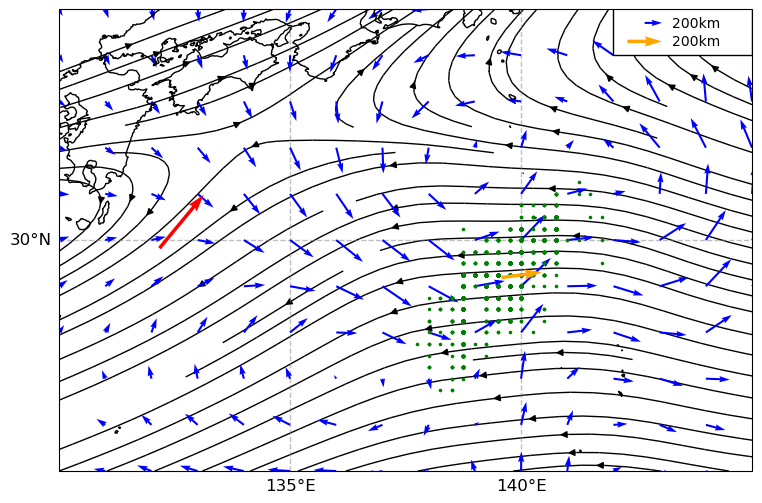

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([130, 145, 25, 35])
# ax.set_extent([pca_mid.mean_[0]-5,pca_mid.mean_[0]+5,pca_mid.mean_[1]-5,pca_mid.mean_[1]+5], crs=proj)
if steering_sign != 'y':
    contour = ax.contourf(lon_grid, lat_grid, cov_var_ratio, cmap=pwp, levels=np.linspace(-200, 200, 17), transform=ccrs.PlateCarree())
    cbar = plt.colorbar(contour, ax=ax, label=f'Cov(distance, {choosen_factor}) / Var({choosen_factor})', shrink = 1)
    cbar.locator = mticker.MultipleLocator(50)  # Set the colorbar ticks to have an interval of 0.5
    cbar.update_ticks()
ax.scatter(mid_pos[:, 0], mid_pos[:, 1], alpha=1, s=2.5, c='green', zorder = 11)
# setup_map(ax, back_color='n')
ax.coastlines(resolution='10m', color='black', linewidth=1)
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder = 0)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))


if steering_sign == 'y':
    # if axis_opt != 'quiver':
    # ax.barbs(lon_grid[::8,::8], lat_grid[::8,::8], u_mean[::8,::8], v_mean[::8,::8], length=5, linewidth=0.5, color = 'black')
    ax.streamplot(lon_grid, lat_grid, u_mean, v_mean, density=1, linewidth=1, color='black', minlength=0.2, zorder = 0)
    qui_length = 200
    # ax.quiver(lon_grid[::4,::4], lat_grid[::4,::4], u_mean[::4,::4], v_mean[::4,::4], scale=qui_length, color = 'black', zorder = 11)

            

    # 태풍 영역 안에 들어오는 sensitivity의 방향 평균을 구하기, 정규화
    u_mean_inner = np.mean(cov_var_quiver['u'])
    v_mean_inner = np.mean(cov_var_quiver['v'])
    u_steer = np.mean(steer_quiver['u'])
    v_steer = np.mean(steer_quiver['v'])


    
    # qui = ax.quiver(lon_grid[::4, ::4], lat_grid[::4, ::4], cov_var_ratio['u'][::4, ::4], cov_var_ratio['v'][::4, ::4], scale=qui_length*4, color='blue', width=0.003)
    # key = ax.quiverkey(qui, X=0.87, Y=0.97, U=qui_length, label=f'{qui_length}km', labelpos='E', zorder = 17)
    
    # mean_qui = ax.quiver(pca_mid.mean_[0], pca_mid.mean_[1], u_mean_inner, v_mean_inner, scale=qui_length*4, color='orange', width=0.005, zorder = 12)
    # mean_key = ax.quiverkey(mean_qui, X=0.87, Y=0.93, U=qui_length/5, label=f'{int(qui_length/5)}km', labelpos='E', zorder = 17)


    #Sensitivity를 파란색 화살표로 표시
    qui = ax.quiver(lon_grid[::4, ::4], lat_grid[::4, ::4], cov_var_ratio['u'][::4, ::4], cov_var_ratio['v'][::4, ::4], scale=qui_length*40, color='blue', width=0.003)
    key = ax.quiverkey(qui, X=0.87, Y=0.97, U=qui_length, label=f'{qui_length}km', labelpos='E')

    # 태풍 영역에 들어오는 sensitivity의 방향 평균을 구하기
    inner_qui = ax.quiver(pca_mid.mean_[0], pca_mid.mean_[1], u_mean_inner, v_mean_inner, scale=qui_length*20, color='orange', width=0.005, zorder = 12)
    inner_key = ax.quiverkey(inner_qui, X=0.87, Y=0.93, U=qui_length, label=f'{int(qui_length)}km', labelpos='E')

    # steer_qui = ax.quiver(pca_mid.mean_[0],  pca_mid.mean_[1], u_steer, v_steer, scale=100, color='orange', width=0.003, zorder = 12)
    # steer_key = ax.quiverkey(steer_qui, X=0.87, Y=0.89, U=5, label=f'5 m/s', labelpos='E', zorder = 17)
    
    rect = patches.Rectangle((0.8, 0.9), 0.2, 0.15, linewidth=1, edgecolor='black', facecolor='white', transform=ax.transAxes)
    ax.add_patch(rect)
    
    cov_u_dir, cov_v_dir = u_mean_inner/np.sqrt(u_mean_inner**2+v_mean_inner**2), v_mean_inner/np.sqrt(u_mean_inner**2+v_mean_inner**2)
    cov_proj = mid_pos @ np.array([cov_u_dir, cov_v_dir])
    
    correlation = np.corrcoef(cov_proj, tar_proj[:, 0])[0, 1]
    correlations_all.append((predict_interval, correlation))
    dir_all[predict_interval]={'u': u_mean_inner, 'v': v_mean_inner}
        
        
        
else:
    if choosen_factor == 'z':
        cax = ax.contour(lon_grid, lat_grid, non_uv_mean, levels=np.arange(0,15001,60), colors='black')
    elif choosen_factor == 't':
        cax = ax.contour(lon_grid, lat_grid, non_uv_mean, levels=np.arange(200,401,5), colors='black')
    elif choosen_factor == 'q':
        cax = ax.contour(lon_grid, lat_grid, non_uv_mean, levels=np.arange(0,21,1),    colors='black')
    elif choosen_factor == 'u':
        cax = ax.contour(lon_grid, lat_grid, non_uv_mean, levels=np.arange(-100,101,10), colors='black')
    elif choosen_factor == 'v':
        cax = ax.contour(lon_grid, lat_grid, non_uv_mean, levels=np.arange(-100,101,10), colors='black')
    
    cax.clabel()

    
    
ax.quiver(pca_tar.mean_[0], pca_tar.mean_[1], pca_tar.components_[0, 0], pca_tar.components_[0, 1]  , scale=10, color='r', width=0.005, label='Principal Axis')
plt.show()

## **Draw Position-variance-removed sensitvity**

In [8]:
#! only nearby, quiver, 위치 변동 아예 없애기
key_time = datetime(2022,8,27,0)            #처음 시점 지정
start_time = datetime(2022,8,28,0)          #분석 시작 시점
target_time = datetime(2022,9,1,0)          #위치 projection을 구하고자 하는 시간

key_str = key_time.strftime("%m.%d %HUTC")
start_str = start_time.strftime("%m.%d %HUTC")
target_str = target_time.strftime("%m.%d %HUTC")

total_time_range = int((target_time - key_time).total_seconds() / 3600)
start_time_range = int((start_time  - key_time).total_seconds() / 3600)

# 변수 지정
nearby_sign = 'y'                           #가까운 태풍만 추출
steering_sign = 'y'                         #태풍 제거를 진행할 것인지를 판단(steering wind 진행)
distance_threshold = 0                      #가까운 태풍의 거리
choosen_factor_list = ['t','q']             #분석할 변수
altitude_list = [250,500,850]               #분석할 고도
# altitude_list = [1000,700,300,200]
steer_pres = [850,700,600,500,400,300,250]  #steering wind 구할 때 사용하는 고도 바꿀 필요 x
axis_opt = 'quiver'                         #axis 뭘로 잡을지, opt: 위치 상관관계 최대인 axis, tar: 최종 위치의 axis, mid: 중간 위치의 axis, lon: 경도, lat: 위도
data_sign = 'y'                             #기존의 데이터를 사용할 것인지, n이면 새로 구함
min_mem_threshold = 20                       #최소 멤버 수

if nearby_sign == 'y':
    nearby_sign_name = '_nearby'
else:
    nearby_sign_name = ''
    

# steering_sign이 y면 steering wind에 대해서만 구하기
if steering_sign == 'y':
    altitude_list = ['850_200']
    choosen_factor_list = ['steering_wind']



# target_time 때도 살아있는 태풍만 추출
correlations = []
correlations_same = []


# dir_near = {}
group_mem_dict = {}
cov_var_total = {}
cov_var_pw = {}
cov_var_pw_norm = {}
for predict_interval in np.arange(start_time_range,total_time_range+1,6):
# for predict_interval in np.arange(78,total_time_range+1,6):
# for predict_interval in np.arange(start_time_range,72+1,6):
# for predict_interval in np.arange(start_time_range,72+1,6):
# for predict_interval in np.arange(114,115,6):
# for predict_interval in np.arange(18,19,6):
# for predict_interval in [24, 72]:
# for predict_interval in np.arange(120,124,6):
    datetime1 = key_time + timedelta(hours=int(predict_interval))

    cov_var_pw[predict_interval] = {
        'map': {'u': None, 'v': None},
        'inner': {'u': [], 'v': []},
        'inner_each': {'u': [], 'v': []}
    }

    cov_var_pw_norm[predict_interval] = {
        'map': {'u': None, 'v': None},
        'inner': {'u': [], 'v': []},
        'inner_each': {'u': [], 'v': []}
    }
    for choosen_factor in choosen_factor_list:
        for altitude in altitude_list:
            print(altitude)
            cov_var_inner = {'u':[],'v':[]}
            cov_var_inner_each = {'u':[],'v':[]}
            cov_var_inner_norm = {'u':[],'v':[]}
            cov_var_inner_each_norm = {'u':[],'v':[]}
            cov_var_map = {'u':[],'v':[]}
            cov_var_map_norm = {'u':[],'v':[]}
            
            steer_quiver = {'u':[],'v':[]}
            steer_quiver_each = {'u':[],'v':[]}
            
            cov_var_nonuv = []
            u_mean = []
            v_mean = []
            non_uv_mean = []
            
            
            group_num=1
            group_mem=0
            group_mem_dict[predict_interval] = []
            mid_pos_group = []
            
            
            while True:
                ens_num_list = []
                
                for ens in ens_list:
                    if (target_time in ssv_dict[key_time][ens]) and (start_time in ssv_dict[key_time][ens]):
                        ens_num_list.append(ens)
                
                
                # 데이터를 추출합니다
                ens_pos = [(ens, ssv_dict[key_time][ens][target_time]['lon'], ssv_dict[key_time][ens][target_time]['lat']) for ens in ens_num_list]

                # 위도(lat) 기준으로 데이터를 정렬합니다
                pos_sorted_by_lat = sorted(ens_pos, key=lambda x: x[2])  # x[2]는 위도를 나타냅니다

                # 위도가 가장 낮은 10개와 가장 높은 10개를 추출합니다
                group1 = pos_sorted_by_lat[:50]  # 가장 낮은 10개
                group2 = pos_sorted_by_lat[-50:]  # 가장 높은 10개
                group3 = pos_sorted_by_lat[len(pos_sorted_by_lat) // 2 - 5:len(pos_sorted_by_lat) // 2 + 5]
                
                # group1과 group2에 있는 ens 번호만 추출합니다
                group1 = [item[0] for item in group1]
                group2 = [item[0] for item in group2]
                group3 = [item[0] for item in group3]
                
                mid_pos = [(ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']) for ens in ens_num_list]
                tar_pos = [(ssv_dict[key_time][ens][target_time]['lon'], ssv_dict[key_time][ens][target_time]['lat']) for ens in ens_num_list]
                gg_pos = [(ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']) for ens in group1 + group2]
                gg_tar_pos = [(ssv_dict[key_time][ens][target_time]['lon'], ssv_dict[key_time][ens][target_time]['lat']) for ens in group1 + group2]
                
                # NumPy 배열로 변환
                mid_pos, tar_pos, gg_pos, gg_tar_pos = np.array(mid_pos), np.array(tar_pos), np.array(gg_pos), np.array(gg_tar_pos)
                total_mean_lon = np.mean(mid_pos[:,0])
                total_mean_lat = np.mean(mid_pos[:,1])
                
                
                #타겟 위치의 PCA
                corr_pos_tar = np.copy(tar_pos)
                corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
                pca_tar = PCA(n_components=1)
                pca_tar.fit(corr_pos_tar)
                pca_tar.mean_[0] = pca_tar.mean_[0] / np.cos(np.radians(pca_tar.mean_[1])) + np.mean(tar_pos[:, 0])

                # 중간 위치의 PCA
                corr_pos_mid = np.copy(mid_pos)
                corr_pos_mid[:, 0] = (mid_pos[:, 0]-np.mean(mid_pos[:, 0])) * np.cos(np.radians(mid_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
                pca_mid = PCA(n_components=1)
                pca_mid.fit(corr_pos_mid)
                pca_mid.mean_[0] = pca_mid.mean_[0] / np.cos(np.radians(pca_mid.mean_[1])) + np.mean(mid_pos[:, 0])


                mid_total_proj = pca_mid.transform(mid_pos)
                tar_total_proj = pca_tar.transform(tar_pos)
                mid_pos_total = np.copy(mid_pos)
                
            
                #마지막 숫자는 최소 그룹 멤버 개수, 5명 이하면 그룹으로 인정하지 않음 그리고 while문 탈출
                result = find_large_groups(mid_pos, ens_num_list, tar_pos, nearby_sign, distance_threshold, group_num, min_mem_threshold)
                group_num+=1
                if not result:
                    print(f"No more groups with at least {min_mem_threshold} members found.")
                    break
                
                tar_pos, mid_pos, group_idx = result
                group_mem+=len(group_idx)
                group_mem_dict[predict_interval].append(group_idx)
                mid_pos_group.append(mid_pos[0])
                # if np.all(mid_pos == mid_pos[0]):
                #     print("모든 내용물이 동일합니다.")
                # else:
                #     print("모든 내용물이 동일하지 않습니다.")
                print(f'{predict_interval}h', f'총 개수:{len(ens_num_list)}, 누적 개수:{group_mem}, 현재 그룹 개수:{len(group_idx)}')
                    
                
                
                #distance 구하기
                corr_pos_tar = np.copy(tar_pos) #nearby를 고려하여 다시 target 부르기 PCA는 전체 데이터로 해야되므로 nearby 이전에 진행
                corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
                projection = pca_tar.transform(corr_pos_tar)[:, 0]  # 주축에 투영된 데이터 (1차원)
                principal_component = pca_tar.components_[0]
                # 투영된 데이터의 ensemble mean 계산
                ensemble_mean = np.mean(projection)

                # 각 앙상블 멤버의 투영 데이터와 ensemble mean 사이의 거리 계산

                distances = projection - ensemble_mean
                
                # 각 앙상블 멤버의 거리를 저장
                ensemble_distances = {ens: distance for ens, distance in enumerate(distances)}

                


                fig_dir = f'/home1/jek/Pangu-Weather/plot/Sensitivity/{key_str}/{start_str}_{target_str}_{axis_opt}{nearby_sign_name}/'
                ens_factor_uv=[]
                total_remove_uv = []
                u_mean_each = []
                v_mean_each = []
                
                base_output_path = os.path.join(
                pangu_dir, 
                'output_data', 
                'steering_wind',
                key_str, 
                f'{perturation_scale}ENS{surface_str}{upper_str}', 
                f'{min(ens_list)}_{max(ens_list)}_{start_str}_{target_str}'
            )


                # Paths for saving the arrays
                if steering_sign == 'y':
                    ens_factor_uv_path = os.path.join(base_output_path, 'ens_factor_uv')    #Steering 고도 한번에 고려 (2529, 2, 161, 241)
                    total_remove_uv_path = os.path.join(base_output_path, 'total_remove_uv')#각 고도 나눠서 생각 (2529, 2, 7, 161, 241)
                    u_mean_path = os.path.join(base_output_path, 'u_mean')
                    v_mean_path = os.path.join(base_output_path, 'v_mean')
                    
                    
                    ens_factor_uv = np.load(f'{ens_factor_uv_path}/{predict_interval}h{retro_opt}.npy')
                    total_remove_uv = np.load(f'{total_remove_uv_path}/{predict_interval}h{retro_opt}.npy')
                    
                    # u_mean = np.load(f'{u_mean_path}/{predict_interval}h{retro_opt}.npy')
                    # v_mean = np.load(f'{v_mean_path}/{predict_interval}h{retro_opt}.npy')
                
                    # if nearby_sign == 'y':
                    ens_factor_uv = np.array(ens_factor_uv)[group_idx]
                    u_mean.append(ens_factor_uv[:,0,:,:])
                    v_mean.append(ens_factor_uv[:,1,:,:])
                
                elif choosen_factor == 'u':
                    ens_factor_uv = ens_factor_uv[:,0,:,:]
                    total_remove_uv = total_remove_uv[:,0,:,:,:]
                    
                elif choosen_factor == 'v':
                    ens_factor_uv = ens_factor_uv[:,1,:,:]
                    total_remove_uv = total_remove_uv[:,1,:,:,:]
                    
                else:
                    ens_factor_uv=[]
                    for ens in np.array(ens_num_list)[group_idx]:
                        output_data_dir = rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/{ens}'
                        met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid)
                        ens_factor_uv.append(met.met_data(choosen_factor, level = altitude))
                    ens_factor_uv = np.array(ens_factor_uv)
                    non_uv_mean.append(ens_factor_uv)                
                

                # z_500 데이터를 numpy 배열로 변환
                ens_factor = np.copy(np.array(ens_factor_uv))

                if steering_sign == 'y':
                    ens_factor_quiver = (ens_factor[:,0,:,:], ens_factor[:,1,:,:])
                    cov_var_ratio = {}
                    cov_var_ratio_norm = {}
                    
                    for ens_factor, uv_key in zip(ens_factor_quiver,['u','v']):
                        ens_factor_std = np.std(ens_factor, axis=0)
                        ens_norm = (ens_factor - np.mean(ens_factor, axis=0)) / ens_factor_std

                        # 공분산 및 분산 계산
                        cov_matrix = np.zeros_like(ens_factor[0])
                        var_matrix = np.zeros_like(ens_factor[0])
                        cov_matrix_norm = np.zeros_like(ens_norm[0])
                        var_matrix_norm = np.zeros_like(ens_norm[0])

                        for i in range(ens_factor.shape[1]):  # lat 방향
                            for j in range(ens_factor.shape[2]):  # lon 방향
                                cov_matrix[i, j] = np.cov(distances, ens_factor[:, i, j])[0, 1]
                                var_matrix[i, j] = np.var(ens_factor[:,i,j])
                                cov_matrix_norm[i, j] = np.cov(distances, ens_norm[:, i, j])[0, 1]
                                var_matrix_norm[i, j] = np.var(ens_norm[:,i,j])

                    

                        # NaN 또는 Inf 값을 0으로 대체
                        cov_var_ratio[uv_key] = np.nan_to_num(cov_matrix / var_matrix * 111)
                        cov_var_ratio_norm[uv_key] = np.nan_to_num(cov_matrix_norm / var_matrix_norm * 111)
                        
                        

                    dis = haversine_distance(lat_grid, lon_grid, np.ones_like(lat_grid)*mid_pos[0,1], np.ones_like(lat_grid)*mid_pos[0,0])
                    
                    us = []
                    vs = []
                    
                    for k in range(len(mid_pos)):
                        cov_var_map['u'].append(cov_var_ratio['u'])
                        cov_var_map['v'].append(cov_var_ratio['v'])
                        cov_var_map_norm['u'].append(cov_var_ratio_norm['u'])
                        cov_var_map_norm['v'].append(cov_var_ratio_norm['v'])
                        
                        cov_var_inner['u'].append(np.mean(cov_var_ratio['u'][dis <= 333]))
                        cov_var_inner['v'].append(np.mean(cov_var_ratio['v'][dis <= 333]))
                        cov_var_inner_norm['u'].append(np.mean(cov_var_ratio_norm['u'][dis <= 333]))
                        cov_var_inner_norm['v'].append(np.mean(cov_var_ratio_norm['v'][dis <= 333]))
                        steer_quiver['u'].append(np.mean(ens_factor_uv[k,0,:,:][dis <= 333]))
                        steer_quiver['v'].append(np.mean(ens_factor_uv[k,1,:,:][dis <= 333]))
                        us.append(np.mean(ens_factor_uv[k,0,:,:][dis <= 333]))
                        vs.append(np.mean(ens_factor_uv[k,1,:,:][dis <= 333]))
                    
                    cov_var_inner_each['u'].append(np.mean(cov_var_ratio['u'][dis <= 333]))
                    cov_var_inner_each['v'].append(np.mean(cov_var_ratio['v'][dis <= 333])) 
                    cov_var_inner_each_norm['u'].append(np.mean(cov_var_ratio_norm['u'][dis <= 333]))
                    cov_var_inner_each_norm['v'].append(np.mean(cov_var_ratio_norm['v'][dis <= 333]))
                    steer_quiver_each['u'].append(np.mean(us))
                    steer_quiver_each['v'].append(np.mean(vs))
                
                               
                
                else:
                    ens_factor_std = np.std(ens_factor, axis=0)
                    ens_factor = (ens_factor - np.mean(ens_factor, axis=0)) / ens_factor_std

                    # 공분산 및 분산 계산
                    cov_matrix = np.zeros_like(ens_factor[0])
                    var_matrix = np.zeros_like(ens_factor[0])

                    for i in range(ens_factor.shape[1]):  # lat 방향
                        for j in range(ens_factor.shape[2]):  # lon 방향
                            cov_matrix[i, j] = np.cov(distances, ens_factor[:, i, j])[0, 1]
                            var_matrix[i, j] = np.var(ens_factor[:,i,j])

                    # NaN 또는 Inf 값을 0으로 대체
                    cov_var_ratio = np.nan_to_num(cov_matrix / var_matrix * 111)
                    for mp in mid_pos:
                        cov_var_nonuv.append(cov_var_ratio)

    cov_var_pw[predict_interval]['map']['u'] = cov_var_map['u']
    cov_var_pw[predict_interval]['map']['v'] = cov_var_map['v']
    cov_var_pw[predict_interval]['inner']['u'] = cov_var_inner['u']
    cov_var_pw[predict_interval]['inner']['v'] = cov_var_inner['v']
    cov_var_pw[predict_interval]['inner_each']['u'] = cov_var_inner_each['u']
    cov_var_pw[predict_interval]['inner_each']['v'] = cov_var_inner_each['v']

    cov_var_pw_norm[predict_interval]['map']['u'] = cov_var_map_norm['u']
    cov_var_pw_norm[predict_interval]['map']['v'] = cov_var_map_norm['v']
    cov_var_pw_norm[predict_interval]['inner']['u'] = cov_var_inner_norm['u']
    cov_var_pw_norm[predict_interval]['inner']['v'] = cov_var_inner_norm['v']
    cov_var_pw_norm[predict_interval]['inner_each']['u'] = cov_var_inner_each_norm['u']
    cov_var_pw_norm[predict_interval]['inner_each']['v'] = cov_var_inner_each_norm['v']


with open('/home1/jek/Pangu-Weather/output_data/cov_var/cov_var_pw.pkl', 'wb') as f:
    pickle.dump(cov_var_pw, f)

with open('/home1/jek/Pangu-Weather/output_data/cov_var/cov_var_pw_norm.pkl', 'wb') as f:
    pickle.dump(cov_var_pw_norm, f)

#%%
            # steering wind를 그리기 위한 코드
            # fig, ax = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
            # ax.set_extent([130,145,25,35], crs=proj)
            # gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='-')
            # gl.top_labels = False
            # gl.right_labels = False
            # gl.xlabel_style = {'size': 12}
            # gl.ylabel_style = {'size': 12}
        
            # gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
            # gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
            # # gl.ylocator = mticker.MultipleLocator(5)
            # ax.coastlines(zorder = 0)
            # mid_pos_group = np.array(mid_pos_group)
            # ax.scatter(mid_pos_group[:, 0], mid_pos_group[:, 1], alpha=1, s=2.5, c='green', zorder = 11)
        
            
            # if steering_sign == 'y':

            #     u_mean_fig = np.mean(np.concatenate(u_mean, axis=0), axis=0)
            #     v_mean_fig = np.mean(np.concatenate(v_mean, axis=0), axis=0)
            #     ax.barbs(lon_grid[::8,::8], lat_grid[::8,::8], u_mean_fig[::8,::8], v_mean_fig[::8,::8], length=5, linewidth=0.5, color = 'black')

                            
            #     # 태풍 영역 안에 들어오는 sensitivity의 방향 평균을 구하기, 정규화
            #     u_quiver = np.mean(np.array(cov_var_map['u']), axis=0)
            #     v_quiver = np.mean(np.array(cov_var_map['v']), axis=0)
                
            #     u_mean_inner = np.mean(cov_var_inner['u'])
            #     v_mean_inner = np.mean(cov_var_inner['v'])
                
            #     u_steer = np.mean(steer_quiver['u'])
            #     v_steer = np.mean(steer_quiver['v'])
            #     cov_var_total[predict_interval] = {'u': u_quiver,'v':v_quiver}
                
            #     qui_length = 500
                
            #     #Sensitivity를 파란색 화살표로 표시
            #     qui = ax.quiver(lon_grid[::4, ::4], lat_grid[::4, ::4], u_quiver[::4, ::4], v_quiver[::4, ::4], scale=qui_length*20, color='blue', width=0.003)
            #     key = ax.quiverkey(qui, X=0.9, Y=0.97, U=qui_length, label=f'{qui_length}km', labelpos='E')
                
            #     # 태풍 영역에 들어오는 sensitivity의 방향 평균을 구하기
            #     inner_qui = ax.quiver(total_mean_lon, total_mean_lat, u_mean_inner, v_mean_inner, scale=qui_length*4, color='purple', width=0.003, zorder = 12)
            #     inner_key = ax.quiverkey(inner_qui, X=0.9, Y=0.93, U=qui_length/5, label=f'{int(qui_length/5)}km', labelpos='E')
            
            #     # dir_near[predict_interval]={'u': u_mean_inner, 'v': v_mean_inner}
            #     steer_qui = ax.quiver(total_mean_lon, total_mean_lat, u_steer, v_steer, scale=100, color='orange', width=0.003, zorder = 12)
            #     steer_key = ax.quiverkey(steer_qui, X=0.9, Y=0.89, U=5, label=f'5 m/s', labelpos='E')
            
            
            #     # 각 그룹의 길이를 계산합니다.
            #     lengths = [len(mem) for mem in group_mem_dict[predict_interval]]

            #     # 모든 그룹의 총 길이를 계산합니다.
            #     total_length = sum(lengths)

            #     # 각 그룹의 길이를 총 길이로 나누어 비율을 계산합니다.
            #     length_ratio = [length / total_length for length in lengths]
            #     # length_ratio = [len(mem) for mem in group_mem_dict[predict_interval]]/sum([len(mem) for mem in group_mem_dict[predict_interval]])
            #     for mid_pos_g, cov_var_u, cov_var_v, steer_u_each, steer_v_each,lr in zip(mid_pos_group, cov_var_inner_each['u'], cov_var_inner_each['v'], steer_quiver_each['u'],steer_quiver_each['v'],length_ratio):
            #         # print(np.log1p(lr))
            #         # lr = min(1, lr*2)
            #         ax.quiver(mid_pos_g[0], mid_pos_g[1], cov_var_u, cov_var_v, scale=qui_length*4, color='brown', width=0.002, zorder = 11, alpha = 0.4)
            #         # ax.quiver(mid_pos_g[0], mid_pos_g[1], steer_u_each, steer_v_each, scale=200, color='yellow', width=0.002, zorder = 11, alpha = 0.4)

            #     rect = patches.Rectangle((0.84, 0.87), 0.16, 0.15, linewidth=1, edgecolor='black', facecolor='white', transform=ax.transAxes)
            #     ax.add_patch(rect)
                
            #     u_mean_inner, v_mean_inner
            #     cov_u_dir, cov_v_dir = u_mean_inner/np.sqrt(u_mean_inner**2+v_mean_inner**2), v_mean_inner/np.sqrt(u_mean_inner**2+v_mean_inner**2)
            #     cov_proj = mid_pos_total @ np.array([cov_u_dir, cov_v_dir])
                
                
            #     correlation = np.corrcoef(mid_total_proj[:, 0], tar_total_proj[:, 0])[0, 1]
            #     correlations.append((predict_interval, correlation))
                
            #     correlation = np.corrcoef(cov_proj, tar_total_proj[:, 0])[0, 1]
            #     correlations_same.append((predict_interval, correlation))

            
            
            # else:
            #     # print(np.shape((non_uv_mean)))
            #     non_uv_mean = np.concatenate(non_uv_mean, axis=0)
            #     # print(np.shape(non_uv_mean))
            #     # print(non_uv_mean[0]==non_uv_mean[1],non_uv_mean[0]==non_uv_mean[-1])
            #     # print(np.shape(non_uv_mean))
            #     non_uv_mean = np.mean(non_uv_mean, axis=0)
            #     # print(np.shape(cov_var_nonuv))
            #     # print(cov_var_nonuv[0] == cov_var_nonuv[1], cov_var_nonuv[0] == cov_var_nonuv[-1])
            #     cov_var_nonuv = np.mean(cov_var_nonuv, axis=0)
            #     contour = ax.contourf(lon_grid, lat_grid, cov_var_nonuv, cmap=pwp, levels=np.linspace(-200, 200, 17), transform=ccrs.PlateCarree())
            #     cbar = plt.colorbar(contour, ax=ax, label=f'Cov(distance, {choosen_factor}) / Var({choosen_factor})', shrink = 1)
            #     cbar.locator = mticker.MultipleLocator(50)  # Set the colorbar ticks to have an interval of 0.5
            #     cbar.update_ticks()
                
            #     if choosen_factor == 'z':
            #         cax = ax.contour(lon_grid, lat_grid, non_uv_mean, levels=np.arange(0,15001,60), colors='black')    
            #     elif choosen_factor == 't':
            #         cax = ax.contour(lon_grid, lat_grid, non_uv_mean, levels=np.arange(0,401,2), colors='black')
            #     elif choosen_factor == 'q':
            #         cax = ax.contour(lon_grid, lat_grid, non_uv_mean, levels=np.arange(0,21,1),    colors='black')
            
            #     cax.clabel()
                
            # ax.quiver(pca_tar.mean_[0], pca_tar.mean_[1], pca_tar.components_[0, 0], pca_tar.components_[0, 1]  , scale=20, color='r', width=0.003, label='Principal Axis')

            # # fig_dir = f'/home1/jek/Pangu-Weather/plot/Sensitivity/{storm_name}_{start_str}_{target_str}_z/{choosen_factor}/'
            # if not os.path.exists(f'{fig_dir}/{choosen_factor}/{altitude}hPa'):
            #     os.makedirs(f'{fig_dir}/{choosen_factor}/{altitude}hPa')
            # else:
            #     pass
            
            # plt.show()

850_200
24h 총 개수:2529, 누적 개수:1831, 현재 그룹 개수:1831
24h 총 개수:2529, 누적 개수:2044, 현재 그룹 개수:213
24h 총 개수:2529, 누적 개수:2182, 현재 그룹 개수:138
24h 총 개수:2529, 누적 개수:2264, 현재 그룹 개수:82
24h 총 개수:2529, 누적 개수:2313, 현재 그룹 개수:49
24h 총 개수:2529, 누적 개수:2356, 현재 그룹 개수:43
24h 총 개수:2529, 누적 개수:2387, 현재 그룹 개수:31
24h 총 개수:2529, 누적 개수:2416, 현재 그룹 개수:29
24h 총 개수:2529, 누적 개수:2444, 현재 그룹 개수:28
24h 총 개수:2529, 누적 개수:2472, 현재 그룹 개수:28
No more groups with at least 20 members found.
850_200
30h 총 개수:2529, 누적 개수:1166, 현재 그룹 개수:1166
30h 총 개수:2529, 누적 개수:1436, 현재 그룹 개수:270
30h 총 개수:2529, 누적 개수:1676, 현재 그룹 개수:240
30h 총 개수:2529, 누적 개수:1877, 현재 그룹 개수:201
30h 총 개수:2529, 누적 개수:2069, 현재 그룹 개수:192
30h 총 개수:2529, 누적 개수:2178, 현재 그룹 개수:109
30h 총 개수:2529, 누적 개수:2239, 현재 그룹 개수:61
30h 총 개수:2529, 누적 개수:2296, 현재 그룹 개수:57
30h 총 개수:2529, 누적 개수:2345, 현재 그룹 개수:49
30h 총 개수:2529, 누적 개수:2389, 현재 그룹 개수:44
30h 총 개수:2529, 누적 개수:2419, 현재 그룹 개수:30
30h 총 개수:2529, 누적 개수:2443, 현재 그룹 개수:24
No more groups with at least 20 members found.
850_200
36h 총 개수:2529

### Position variance-removed sensitivity figure

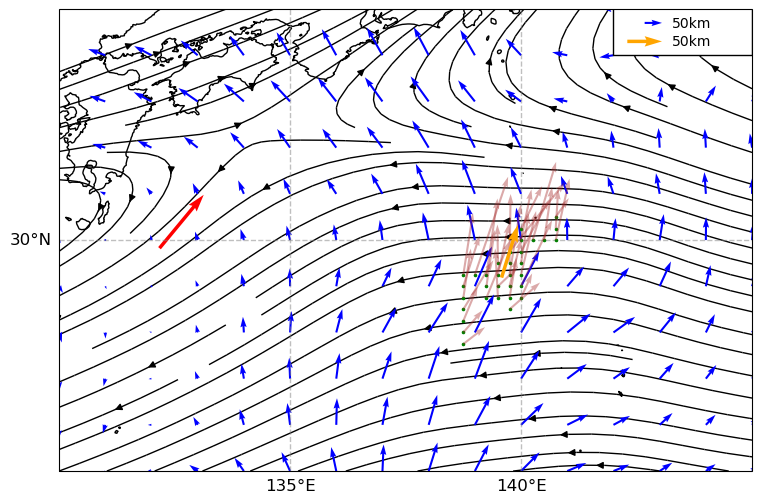

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# ax.set_extent([pca_mid.mean_[0]-5,pca_mid.mean_[0]+5,pca_mid.mean_[1]-5,pca_mid.mean_[1]+5], crs=proj)
ax.set_extent([130,145,25,35], crs=proj)
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
# gl.ylocator = mticker.MultipleLocator(5)
ax.coastlines(zorder = 0)
mid_pos_group = np.array(mid_pos_group)
ax.scatter(mid_pos_group[:, 0], mid_pos_group[:, 1], alpha=1, s=2.5, c='green', zorder = 11)



u_mean_fig = np.mean(np.concatenate(u_mean, axis=0), axis=0)
v_mean_fig = np.mean(np.concatenate(v_mean, axis=0), axis=0)
# ax.barbs(lon_grid[::8,::8], lat_grid[::8,::8], u_mean_fig[::8,::8], v_mean_fig[::8,::8], length=5, linewidth=0.5, color = 'black')
ax.streamplot(lon_grid, lat_grid, u_mean_fig, v_mean_fig, density=1, linewidth=1, color='black', minlength=0.2, zorder = 0)
            
# 태풍 영역 안에 들어오는 sensitivity의 방향 평균을 구하기, 정규화
u_quiver = np.mean(np.array(cov_var_map['u']), axis=0)
v_quiver = np.mean(np.array(cov_var_map['v']), axis=0)

u_mean_inner = np.mean(cov_var_inner['u'])
v_mean_inner = np.mean(cov_var_inner['v'])

u_steer = np.mean(steer_quiver['u'])
v_steer = np.mean(steer_quiver['v'])
cov_var_total[predict_interval] = {'u': u_quiver,'v':v_quiver}

qui_length = 50

#Sensitivity를 파란색 화살표로 표시
qui = ax.quiver(lon_grid[::4, ::4], lat_grid[::4, ::4], u_quiver[::4, ::4], v_quiver[::4, ::4], scale=qui_length*40, color='blue', width=0.003)
key = ax.quiverkey(qui, X=0.87, Y=0.97, U=qui_length, label=f'{int(qui_length)}km', labelpos='E')

# 태풍 영역에 들어오는 sensitivity의 방향 평균을 구하기
inner_qui = ax.quiver(total_mean_lon, total_mean_lat, u_mean_inner, v_mean_inner, scale=qui_length*20, color='orange', width=0.005, zorder = 12)
inner_key = ax.quiverkey(inner_qui, X=0.87, Y=0.93, U=qui_length, label=f'{int(qui_length)}km', labelpos='E')

# dir_near[predict_interval]={'u': u_mean_inner, 'v': v_mean_inner}
# steer_qui = ax.quiver(total_mean_lon, total_mean_lat, u_steer, v_steer, scale=100, color='orange', width=0.005, zorder = 12)
# steer_key = ax.quiverkey(steer_qui, X=0.87, Y=0.89, U=5, label=f'5 m/s', labelpos='E')


# 각 그룹의 길이를 계산합니다.
lengths = [len(mem) for mem in group_mem_dict[predict_interval]]

# 모든 그룹의 총 길이를 계산합니다.
total_length = sum(lengths)

# 각 그룹의 길이를 총 길이로 나누어 비율을 계산합니다.
length_ratio = [length / total_length for length in lengths]
# length_ratio = [len(mem) for mem in group_mem_dict[predict_interval]]/sum([len(mem) for mem in group_mem_dict[predict_interval]])
for mid_pos_g, cov_var_u, cov_var_v, steer_u_each, steer_v_each,lr in zip(mid_pos_group, cov_var_inner_each['u'], cov_var_inner_each['v'], steer_quiver_each['u'],steer_quiver_each['v'],length_ratio):
    # print(np.log1p(lr))
    # lr = min(1, lr*2)
    ax.quiver(mid_pos_g[0], mid_pos_g[1], cov_var_u, cov_var_v, scale=qui_length*20, color='brown', width=0.003, zorder = 11, alpha = 0.4)
    # ax.quiver(mid_pos_g[0], mid_pos_g[1], steer_u_each, steer_v_each, scale=200, color='yellow', width=0.002, zorder = 11, alpha = 0.4)

rect = patches.Rectangle((0.8, 0.9), 0.2, 0.15, linewidth=1, edgecolor='black', facecolor='white', transform=ax.transAxes)
ax.add_patch(rect)

u_mean_inner, v_mean_inner
cov_u_dir, cov_v_dir = u_mean_inner/np.sqrt(u_mean_inner**2+v_mean_inner**2), v_mean_inner/np.sqrt(u_mean_inner**2+v_mean_inner**2)
cov_proj = mid_pos_total @ np.array([cov_u_dir, cov_v_dir])
ax.quiver(pca_tar.mean_[0], pca_tar.mean_[1], pca_tar.components_[0, 0], pca_tar.components_[0, 1]  , scale=10, color='r', width=0.005, label='Principal Axis')

plt.show()